In [16]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [17]:
d1 = 183.3 #joint 1 height [mm]
d2 = 737.31 #joint 2 radius [mm]
d3 = 387.8 #joint 3 radius [mm]
d4 = -95.5 #joint 4 radius [mm]
d5 = 115.5 #joint 5 radius [mm]
d6 = 76.8 #end effector offset
alpha = sp.pi/2 #standard 90 degree angle



In [18]:
#Initialize symbols
thetai = sp.Symbol('theta_i')

t = sp.Symbol('t')
ai = sp.Symbol('a_i')
di = sp.Symbol('d_i')
alphai = sp.Symbol('alpha_i')
pi = sp.Symbol('pi')

In [19]:
thetas = sp.symbols('theta_1:7')
dh_theta = [thetas[0], sp.pi/2 + thetas[1], thetas[2], sp.pi/2 + thetas[3], thetas[4], thetas[5]]
dh_a = [0, d2, d3, 0, 0, 0]
dh_d = [d1, 0, 0, -d4, d5, d6]
dh_alpha = [alpha, 0, 0, alpha, -alpha, 0]

In [20]:
#Create dh table based on chosen coordinate frames

dh_table = {
    "": ["to 1", "to 2", "to 3", "to 4", "to 5", "to 6"],
    thetai: [dh_theta[0],dh_theta[1],dh_theta[2],dh_theta[3],dh_theta[4],dh_theta[5]],
    ai: [dh_a[0],dh_a[1],dh_a[2],dh_a[3],dh_a[4],dh_a[5]],
    di: [dh_d[0],dh_d[1],dh_d[2],dh_d[3],dh_d[4],dh_d[5]],
    alphai: [dh_alpha[0],dh_alpha[1],dh_alpha[2],dh_alpha[3],dh_alpha[4],dh_alpha[5]]

}

df = pd.DataFrame(dh_table)
df

,,theta_i,a_i,d_i,alpha_i
0,to 1,theta_1,0.00,183.3,pi/2
1,to 2,theta_2 + pi/2,737.31,0.0,0
2,to 3,theta_3,387.80,0.0,0
3,to 4,theta_4 + pi/2,0.00,95.5,pi/2
4,to 5,theta_5,0.00,115.5,-pi/2
5,to 6,theta_6,0.00,76.8,0


In [21]:
A_array = [sp.zeros(4,4)]*6
for i in range(0,6):
    A_array[i] = sp.Matrix([
        [sp.cos(dh_theta[i]),-sp.sin(dh_theta[i])*sp.cos(dh_alpha[i]),sp.sin(dh_theta[i])*sp.sin(dh_alpha[i]),dh_a[i]*sp.cos(dh_theta[i])],
        [sp.sin(dh_theta[i]),sp.cos(dh_theta[i])*sp.cos(dh_alpha[i]),-sp.cos(dh_theta[i])*sp.sin(dh_alpha[i]),dh_a[i]*sp.sin(dh_theta[i])],
        [0,sp.sin(dh_alpha[i]),sp.cos(dh_alpha[i]),dh_d[i]],
        [0,0,0,1]
    ])

A_final = A_array[0]
for i in range(1,6):
    A_final = A_final*A_array[i]

In [22]:
def subs_function(matrix,sub_values):
    result = matrix.subs([
        (thetas[0],sub_values[0]),
        (thetas[1],sub_values[1]),
        (thetas[2],sub_values[2]),
        (thetas[3],sub_values[3]),
        (thetas[4],sub_values[4]),
        (thetas[5],sub_values[5])     
    ])
    return result

def subs_position_vector(matrix,sub_values):
    msubs = matrix.subs([
        (thetas[0],sub_values[0]),
        (thetas[1],sub_values[1]),
        (thetas[2],sub_values[2]),
        (thetas[3],sub_values[3]),
        (thetas[4],sub_values[4]),
        (thetas[5],sub_values[5])   
    ])
    result = sp.Matrix([
        [msubs[0,3]],
        [msubs[1,3]],
        [msubs[2,3]],
        [0],
        [0],
        [0]
    ])
    return result


In [23]:


#Validate transformation matrix:
val_matrix = sp.Matrix([
    [0, sp.pi/2, 0, 0, 0],
    [0, 0, sp.pi/2, 0, 0],
    [0, 0, 0, sp.pi/2, 0],
    [0, 0, 0, 0, sp.pi/2],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

A_vals = [0]*5
for i in range(0,5):
    A_vals[i] = subs_function(A_final,val_matrix[:,i])


pos_vals = ["start positiion","first joint rotated 90 degrees","shoulder rotated 90 degrees","elbow rotated 90 degrees","wrist rotated 90 degrees"]
print("Transformation matrix validation")
for i in range(0,5):
    print("---------------")
    print(pos_vals[i])
    print(
        "x = ",((A_vals[i])[0,3]).round(2),
        "y = ",((A_vals[i])[1,3]).round(2),
        "z = ",((A_vals[i])[2,3]).round(2))




Transformation matrix validation
---------------
start positiion
x =  0 y =  -172.30 z =  1423.91
---------------
first joint rotated 90 degrees
x =  172.30 y =  0 z =  1423.91
---------------
shoulder rotated 90 degrees
x =  -1240.61 y =  -172.30 z =  183.30
---------------
elbow rotated 90 degrees
x =  -503.30 y =  -172.30 z =  920.61
---------------
wrist rotated 90 degrees
x =  -115.50 y =  -172.30 z =  1308.41


In [24]:
#Create O matrix
O = sp.zeros(3,7)
product = sp.eye(4)
for i in range(1,7):
    product = product*A_array[i-1]
    O[0,i] = product[0,3]
    O[1,i] = product[1,3]
    O[2,i] = product[2,3]



#Create Z matrix
z = sp.zeros(3,7)
z[0,0] = 0
z[1,0] = 0
z[2,0] = 1
newproduct = sp.eye(4)
for i in range(1,7):
    product = newproduct*A_array[i-1]
    z[0,i] = newproduct[0,2]
    z[1,i] = newproduct[1,2]
    z[2,i] = newproduct[2,2]



In [25]:
#initialize inputs
increment = 0.1 #time increment [s]
duration = 20 #total time [s]
arraysize = int(duration/increment) 
time = np.arange(0, duration, increment) #time array

#initial end effector posiitons with respect to base frame [mm]
ee_x_initial = 0 
ee_y_initial = -172.3-45
ee_z_initial = d1+d2+d3+d5

#Separate end effector path into 6 paths
path1_x_final = -50 #start position x of drawn shape
path1_y_final = ee_y_initial - 10 #start position y of drawn shape
path1_z_final = 1350 #start position z of drawn shape

#calculate distances traveled during paths
path1_distance = sp.sqrt(((ee_x_initial-path1_x_final)**2)+((ee_y_initial-path1_y_final)**2)+(ee_z_initial-path1_z_final)**2)
path2_distance = 50*sp.pi
path3_distance = 50
path4_distance = 100
path5_distance = 50
path6_distance = path1_distance
total_distance = path1_distance+path2_distance+path3_distance+path4_distance+path5_distance+path6_distance

#calculate time taken for each path
path1_time = (path1_distance/total_distance)*duration
path2_time = (path2_distance/total_distance)*duration
path3_time = (path3_distance/total_distance)*duration
path4_time = (path4_distance/total_distance)*duration
path5_time = (path5_distance/total_distance)*duration
path6_time = (path6_distance/total_distance)*duration

#calculate start time of each path
path1_start = 0
path2_start = path1_time.round(1)
path3_start = (path2_start+path2_time).round(1)
path4_start = (path3_start+path3_time).round(1)
path5_start = (path4_start+path4_time).round(1)
path6_start = (path5_start+path5_time).round(1)




In [26]:

#calculate path1 velocities from path 1 time and distance
path1_xdot = (path1_x_final-ee_x_initial)/path1_time
path1_ydot = (path1_y_final-ee_y_initial)/path1_time
path1_zdot = (path1_z_final-ee_z_initial)/path1_time

#equation for path 2 position with respec to time
path2_x = path1_x_final-(50*sp.cos((sp.pi/path2_time)*t))
path2_y = path1_y_final
path2_z = path1_z_final+(50*sp.sin((sp.pi/path2_time)*t))

#equation for path 2 velocities with repect to time
path2_xdot = sp.diff(path2_x,t)
path2_ydot = sp.diff(path2_y,t)
path2_zdot = sp.diff(path2_z,t)

#calculate path 3 velocities
path3_xdot = 0
path3_ydot = 0
path3_zdot = -50/path3_time

#calculate path 4 velocities
path4_xdot = -100/path4_time
path4_ydot = 0
path4_zdot = 0

#calculate path 5 velocities
path5_xdot = 0
path5_ydot = 0
path5_zdot = 50/path5_time

#calculate path 6 velocities
path6_xdot = -path1_xdot
path6_ydot = -path1_ydot
path6_zdot = -path1_zdot

#create xdot master matrix for all paths 
XDOT = sp.Matrix([
    [path1_xdot, path2_xdot, path3_xdot, path4_xdot, path5_xdot, path6_xdot],
    [path1_ydot, path2_ydot, path3_ydot, path4_ydot, path5_ydot, path6_ydot],
    [path1_zdot, path2_zdot, path3_zdot, path4_zdot, path5_zdot, path6_zdot],
    [0,0,0,0,0,0],
    [0,0,0,0,0,0],
    [0,0,0,0,0,0]])


In [27]:

#initialize array sizes for each path (for use in for loops)
path1_arraysize = int(path1_time/increment)
path2_arraysize = int(path2_time/increment)
path3_arraysize = int(path3_time/increment)
path4_arraysize = int(path4_time/increment)
path5_arraysize = int(path5_time/increment)
path6_arraysize = int(path6_time/increment)



In [28]:
from sympy import pprint
# j = sp.zeros(6,6)
# for i in range(0,6):
#     j[0,i] = ((z.col(i)).cross((O.col(6))-(O.col(i))))[0]
#     j[1,i] = ((z.col(i)).cross((O.col(6))-(O.col(i))))[1]
#     j[2,i] = ((z.col(i)).cross((O.col(6))-(O.col(i))))[2]
#     j[3,i] = (z.col(i))[0]
#     j[4,i] = (z.col(i))[1]
#     j[5,i] = (z.col(i))[2]
#     # j[:,i] = sp.Matrix([
#     #     [(z.col(i)).cross((O.col(6))-(O.col(i)))],
#     #     [z.col(i)]])

# pprint(j, use_unicode = True) 

# # path1_position_vector = sp.Matrix([
# #     [XDOT[0,0]],
# #     [XDOT[1,0]],
# #     [XDOT[2,0]],
# #     [XDOT[3,0]],
# #     [XDOT[4,0]],
# #     [XDOT[5,0]]

# # ])


In [29]:
# j

In [31]:
#calculate initial inverse jacobian to obtain initial thetadot values


# jinv_initial = (subs_function(j,sp.zeros(6,1))).pinv()

# thetadot_initial = jinv_initial*XDOT[:,0] #initial thetadot values

# thetadot_initial













In [34]:



thetas_vector = sp.Matrix([
    [thetas[0]],
    [thetas[1]],
    [thetas[2]],
    [thetas[3]],
    [thetas[4]],
    [thetas[5]]
])
JACOBIAN = sp.zeros(6,6)
for i in range (0,6):
    j = (O[:,i]).jacobian(thetas_vector)
    JACOBIAN[0,i] = j[0]
    JACOBIAN[1,i] = j[1]
    JACOBIAN[2,i] = j[2]
    JACOBIAN[3,i] = z[0,i]
    JACOBIAN[4,i] = z[1,i]
    JACOBIAN[5,i] = z[2,i]

JACOBIAN

Matrix([
[0, 0,  737.31*sin(theta_1)*sin(theta_2), 387.8*sin(theta_1)*sin(theta_2)*cos(theta_3) + 737.31*sin(theta_1)*sin(theta_2) + 387.8*sin(theta_1)*sin(theta_3)*cos(theta_2), 387.8*sin(theta_1)*sin(theta_2)*cos(theta_3) + 737.31*sin(theta_1)*sin(theta_2) + 387.8*sin(theta_1)*sin(theta_3)*cos(theta_2) + 95.5*cos(theta_1), 115.5*(-sin(theta_1)*sin(theta_2)*sin(theta_3) + sin(theta_1)*cos(theta_2)*cos(theta_3))*sin(theta_4) + 115.5*(sin(theta_1)*sin(theta_2)*cos(theta_3) + sin(theta_1)*sin(theta_3)*cos(theta_2))*cos(theta_4) + 387.8*sin(theta_1)*sin(theta_2)*cos(theta_3) + 737.31*sin(theta_1)*sin(theta_2) + 387.8*sin(theta_1)*sin(theta_3)*cos(theta_2) + 95.5*cos(theta_1)],
[0, 0, -737.31*cos(theta_1)*cos(theta_2), 387.8*sin(theta_2)*sin(theta_3)*cos(theta_1) - 387.8*cos(theta_1)*cos(theta_2)*cos(theta_3) - 737.31*cos(theta_1)*cos(theta_2),                     387.8*sin(theta_2)*sin(theta_3)*cos(theta_1) - 387.8*cos(theta_1)*cos(theta_2)*cos(theta_3) - 737.31*cos(theta_1)*cos(theta_2),

In [ ]:
#PATH1
#initialize theta/thetadot arrays with zeros
THETA_path1 = sp.zeros(6,path1_arraysize)
THETADOT_path1 = sp.zeros(6,path1_arraysize)


THETADOT_path1[:,0] = thetadot_initial #populate thetadot with initial values

XDOT_path1 = sp.Matrix([
    [XDOT[0,0]],
    [XDOT[1,0]],
    [XDOT[2,0]],
    [XDOT[3,0]],
    [XDOT[4,0]],
    [XDOT[5,0]]
])

for n in range(1,path1_arraysize):
    for i in range(0,6):
        THETA_path1[i,n] = (THETA_path1[i,n-1]+((THETADOT_path1[i,n-1])*increment)).round(10)
    

    
    
    JACOBIANSUBS = subs_function(j,THETA_path1[:,n])
    
    # if JACOBIANSUBS.det() < 0.0001:
    #     jinv = JACOBIANSUBS.pinv()
    # else:
    #     jinv = JACOBIANSUBS.inv()
    jinv = JACOBIANSUBS.pinv()
    thetadot = jinv*XDOT_path1
    
    for i in range(0,6):
        THETADOT_path1[i,n] = thetadot[i]

THETA_path1
# JACOBIAN = path1_position_vector.jacobian(thetas_vector)
# path1_position_vector

# for n in range(1,path1_arraysize):
#     for i in range(0,6):
#         THETA_path1[i,n] = (THETA_path1[i,n-1]+((THETADOT_path1[i,n-1])*increment)).round(5)

    

#Calculate theta/thetadot for path 1
# for n in range(1,path1_arraysize):
#     for i in range(0,6):
#         THETA_path1[i,n] = (THETA_path1[i,n-1]+((THETADOT_path1[i,n-1])*increment)).round(3)
#     jsubs = subs_function(j,
#     THETA_path1[0,n],
#     THETA_path1[1,n],
#     THETA_path1[2,n],
#     THETA_path1[3,n],
#     THETA_path1[4,n],
#     THETA_path1[5,n])

#     if jsubs.det() < 0.0001:
#         jinv = jsubs.pinv()
#     else:
#         jinv = jsubs.inv()
#     thetadot = jinv*(XDOT[:,0])
#     for i in range(0,6):
#         THETADOT_path1[i,n] = thetadot[i]


THETA_path1


NonInvertibleMatrixError: Matrix det == 0; not invertible.

In [ ]:
THETADOT_path1

Matrix([
[-0.000533462222326597 - 7.02691491891299e-5*pi,  0.187309440166306*pi + 1.42199687013324,  1.38152822915856e-5*pi + 0.000104881463321868,  1.39302306448096e-5*pi + 0.000105754116608142,  1.40466170871314e-5*pi + 0.000106637687433834,   1.41644655094193e-5*pi + 0.00010753235717122,  1.42838006053507e-5*pi + 0.000108438313287264,  1.44046474613044e-5*pi + 0.000109355746230201,   1.45270315998482e-5*pi + 0.00011028484975968,   1.4650979359822e-5*pi + 0.000111225823832243,  1.47765171444229e-5*pi + 0.000112178868893012,  1.49036726066943e-5*pi + 0.000113144194875566,  1.50324730551678e-5*pi + 0.000114122009098056,  1.51629475263727e-5*pi + 0.000115112531997067,  1.52951246661247e-5*pi + 0.000116115981043007,  1.54290345355207e-5*pi + 0.000117132584450673,  1.55647072298713e-5*pi + 0.000118162570694601,  1.57021742434013e-5*pi + 0.000119206178869462,  1.58414667559295e-5*pi + 0.000120263645683053,  1.59826173873929e-5*pi + 0.000121335218776112,  1.61256592824896e-5*pi + 0.00012242

In [ ]:
((THETADOT_path1[3,0])*increment)+THETADOT_path1[3,0]

-0.00429325648308851 - 0.000565519858185288*pi

In [ ]:
((subs_function(j,
THETA_path1[0,1],
THETA_path1[1,1],
THETA_path1[2,1],
THETA_path1[3,1],
THETA_path1[4,1],
THETA_path1[5,1])).inv())

Matrix([
[-5.07216305981459e-5, -0.672505276701993, -2.86628483061623e-14,  -2.86020790971449e-6,  2.1572047458323e-10, 0.00389542029656251],
[ -0.0281583149776655,   7.47425787245446,      22.3335101375056,      20587.7274392726,  4.77441792545719e-7,    16.0195608932932],
[  0.0792506199194042,   -19.900506040945,     -64.7954017950761,     -55781.5198804139, -1.29278818850054e-6,    -43.389810383922],
[ -0.0515860867810938,   5.87931959798007,      42.4618916575703,      21935.0488829263,  5.42119975133204e-7,    17.6730385422505],
[ 5.07216166691613e-5,  0.672505092021108,  2.86628400123466e-14, -0.000731382115726968,  5.51622359508096e-8,   0.996104306156921],
[0.000493781839404666,    6.5469285711686,  2.86666606733252e-13,      13258.7434841259,   -0.999999721185641,    9.69721094935312]])

In [ ]:
THETA_path1[1,0]

0

In [ ]:
(THETADOT_path1[1,1]*increment).round(5)

-57.48193

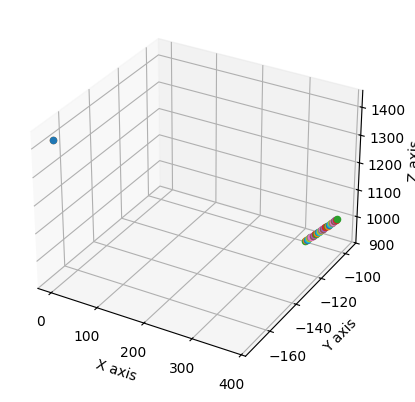

In [ ]:
#PLOTTING END EFFECTOR POSITION
end_effector_xyz = sp.zeros(3,arraysize)
#PATH 1
for i in range(0,path1_arraysize):
    Asubs = A_final.subs([
        (thetas[0],THETA_path1[0,i]),
        (thetas[1],THETA_path1[1,i]),
        (thetas[2],THETA_path1[2,i]),
        (thetas[3],THETA_path1[3,i]),
        (thetas[4],THETA_path1[4,i]),
        (thetas[5],THETA_path1[5,i])])
    end_effector_xyz[0,i] = Asubs[0,3]
    end_effector_xyz[1,i] = Asubs[1,3]
    end_effector_xyz[2,i] = Asubs[2,3]


#PLOT END EFFECTOR PATH
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0,path1_arraysize): #indexing error caused last 3 position values to be 0
    
    ax.scatter([end_effector_xyz[0,i]], [end_effector_xyz[1,i]], [end_effector_xyz[2,i]])


# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')


# Show plot
plt.show()



In [ ]:
#PATH2
THETA_path2 = sp.zeros(6,path2_arraysize)
THETADOT_path2 = sp.zeros(6,path2_arraysize)

for i in range(0,6): #populate theta/thetadot initial values with last values from previous path
    THETA_path2[i,0] = THETA_path1[i,-1]
    THETADOT_path2[i,0] = THETADOT_path1[i,-1]
    
for n in range(1,path2_arraysize):
    for i in range(0,6):
        THETA_path2[i,n] = (THETA_path2[i,n-1]+((THETADOT_path2[i,n-1])*increment)).round(5)
    jsubs = j.subs([
        (theta1,THETA_path2[0,n]),
        (theta2,THETA_path2[1,n]),
        (theta3,THETA_path2[2,n]),
        (theta4,THETA_path2[3,n]),
        (theta5,THETA_path2[4,n]),
        (theta6,THETA_path2[5,n])])
    jinv = jsubs.pinv()
    thetadot = jinv*((XDOT[:,1]).subs([(t,time[n])])) #substituting time values into XDOT
    for i in range(0,6):
        THETADOT_path2[i,n] = thetadot[i]



NameError: name 'theta1' is not defined

In [ ]:
#PATH3
THETA_path3 = sp.zeros(6,path3_arraysize)
THETADOT_path3 = sp.zeros(6,path3_arraysize)

for i in range(0,6):
    THETA_path3[i,0] = THETA_path2[i,-1]
    THETADOT_path3[i,0] = THETADOT_path2[i,-1]

for n in range(1,path3_arraysize):
    for i in range(0,6):
        THETA_path3[i,n] = (THETA_path3[i,n-1]+((THETADOT_path3[i,n-1])*increment)).round(5)
    jsubs = j.subs([
        (theta1,THETA_path3[0,n]),
        (theta2,THETA_path3[1,n]),
        (theta3,THETA_path3[2,n]),
        (theta4,THETA_path3[3,n]),
        (theta5,THETA_path3[4,n]),
        (theta6,THETA_path3[5,n])])
    jinv = jsubs.pinv()
    thetadot = jinv*(XDOT[:,2])
    for i in range(0,6):
        THETADOT_path3[i,n] = thetadot[i]


In [ ]:
#PATH4
THETA_path4 = sp.zeros(6,path4_arraysize)
THETADOT_path4 = sp.zeros(6,path4_arraysize)

for i in range(0,6):
    THETA_path4[i,0] = THETA_path3[i,-1]
    THETADOT_path4[i,0] = THETADOT_path3[i,-1]

for n in range(1,path4_arraysize):
    for i in range(0,6):
        THETA_path4[i,n] = (THETA_path4[i,n-1]+((THETADOT_path4[i,n-1])*increment)).round(5)
    jsubs = j.subs([
        (theta1,THETA_path4[0,n]),
        (theta2,THETA_path4[1,n]),
        (theta3,THETA_path4[2,n]),
        (theta4,THETA_path4[3,n]),
        (theta5,THETA_path4[4,n]),
        (theta6,THETA_path4[5,n])])
    jinv = jsubs.pinv()
    thetadot = jinv*(XDOT[:,3])
    for i in range(0,6):
        THETADOT_path4[i,n] = thetadot[i]


In [ ]:
#PATH 5
THETA_path5 = sp.zeros(6,path5_arraysize)
THETADOT_path5 = sp.zeros(6,path5_arraysize)

for i in range(0,6):
    THETA_path5[i,0] = THETA_path4[i,-1]
    THETADOT_path5[i,0] = THETADOT_path4[i,-1]

for n in range(1,path5_arraysize):
    for i in range(0,6):
        THETA_path5[i,n] = (THETA_path5[i,n-1]+((THETADOT_path5[i,n-1])*increment)).round(5)
    jsubs = j.subs([
        (theta1,THETA_path5[0,n]),
        (theta2,THETA_path5[1,n]),
        (theta3,THETA_path5[2,n]),
        (theta4,THETA_path5[3,n]),
        (theta5,THETA_path5[4,n]),
        (theta6,THETA_path5[5,n])])
    jinv = jsubs.pinv()
    thetadot = jinv*(XDOT[:,4])
    for i in range(0,6):
        THETADOT_path5[i,n] = thetadot[i]



In [ ]:
#PATH 6
THETA_path6 = sp.zeros(6,path6_arraysize)
THETADOT_path6 = sp.zeros(6,path6_arraysize)

for i in range(0,6):
    THETA_path6[i,0] = THETA_path5[i,-1]
    THETADOT_path6[i,0] = THETADOT_path5[i,-1]

for n in range(1,path6_arraysize):
    for i in range(0,6):
        THETA_path6[i,n] = (THETA_path6[i,n-1]+((THETADOT_path6[i,n-1])*increment)).round(5)
    jsubs = j.subs([
        (theta1,THETA_path6[0,n]),
        (theta2,THETA_path6[1,n]),
        (theta3,THETA_path6[2,n]),
        (theta4,THETA_path6[3,n]),
        (theta5,THETA_path6[4,n]),
        (theta6,THETA_path6[5,n])])
    jinv = jsubs.pinv()
    thetadot = jinv*(XDOT[:,5])
    for i in range(0,6):
        THETADOT_path6[i,n] = thetadot[i]




In [ ]:
#PLOTTING END EFFECTOR POSITION
end_effector_xyz = sp.zeros(3,arraysize)
#PATH 1
for i in range(0,path1_arraysize):
    Asubs = A.subs([
        (theta1,THETA_path1[0,i]),
        (theta2,THETA_path1[1,i]),
        (theta3,THETA_path1[2,i]),
        (theta4,THETA_path1[3,i]),
        (theta5,THETA_path1[4,i]),
        (theta6,THETA_path1[5,i])])
    end_effector_xyz[0,i] = Asubs[0,3]
    end_effector_xyz[1,i] = Asubs[1,3]
    end_effector_xyz[2,i] = Asubs[2,3]

#PATH2
r = path1_arraysize
for i in range(r,r+path2_arraysize):
    Asubs = A.subs([
        (theta1,THETA_path2[0,i-r]),
        (theta2,THETA_path2[1,i-r]),
        (theta3,THETA_path2[2,i-r]),
        (theta4,THETA_path2[3,i-r]),
        (theta5,THETA_path2[4,i-r]),
        (theta6,THETA_path2[5,i-r])])
    end_effector_xyz[0,i] = Asubs[0,3]
    end_effector_xyz[1,i] = Asubs[1,3]
    end_effector_xyz[2,i] = Asubs[2,3]

#PATH3
r = r+path2_arraysize
for i in range(r,r+path3_arraysize):
    Asubs = A.subs([
        (theta1,THETA_path3[0,i-r]),
        (theta2,THETA_path3[1,i-r]),
        (theta3,THETA_path3[2,i-r]),
        (theta4,THETA_path3[3,i-r]),
        (theta5,THETA_path3[4,i-r]),
        (theta6,THETA_path3[5,i-r])])
    end_effector_xyz[0,i] = Asubs[0,3]
    end_effector_xyz[1,i] = Asubs[1,3]
    end_effector_xyz[2,i] = Asubs[2,3]

#PATH4
r = r+path3_arraysize
for i in range(r,r+path4_arraysize):
    Asubs = A.subs([
        (theta1,THETA_path4[0,i-r]),
        (theta2,THETA_path4[1,i-r]),
        (theta3,THETA_path4[2,i-r]),
        (theta4,THETA_path4[3,i-r]),
        (theta5,THETA_path4[4,i-r]),
        (theta6,THETA_path4[5,i-r])])
    end_effector_xyz[0,i] = Asubs[0,3]
    end_effector_xyz[1,i] = Asubs[1,3]
    end_effector_xyz[2,i] = Asubs[2,3]

#PATH5
r = r+path4_arraysize
for i in range(r,r+path5_arraysize):
    Asubs = A.subs([
        (theta1,THETA_path5[0,i-r]),
        (theta2,THETA_path5[1,i-r]),
        (theta3,THETA_path5[2,i-r]),
        (theta4,THETA_path5[3,i-r]),
        (theta5,THETA_path5[4,i-r]),
        (theta6,THETA_path5[5,i-r])])
    end_effector_xyz[0,i] = Asubs[0,3]
    end_effector_xyz[1,i] = Asubs[1,3]
    end_effector_xyz[2,i] = Asubs[2,3]

#PATH6
r = r+path5_arraysize
for i in range(r,r+path6_arraysize):
    Asubs = A.subs([
        (theta1,THETA_path6[0,i-r]),
        (theta2,THETA_path6[1,i-r]),
        (theta3,THETA_path6[2,i-r]),
        (theta4,THETA_path6[3,i-r]),
        (theta5,THETA_path6[4,i-r]),
        (theta6,THETA_path6[5,i-r])])
    end_effector_xyz[0,i] = Asubs[0,3]
    end_effector_xyz[1,i] = Asubs[1,3]
    end_effector_xyz[2,i] = Asubs[2,3]



In [ ]:
#PLOT END EFFECTOR PATH
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0,arraysize-3): #indexing error caused last 3 position values to be 0
    
    ax.scatter([end_effector_xyz[0,i]], [end_effector_xyz[1,i]], [end_effector_xyz[2,i]])


# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')


# Show plot
plt.show()

